The following versions of libraries have been used in this question. Please make sure that you use the same versions as well:

- python: 3.7.*
- keras: 2.3.1 
- tensorflow: 2.4.*

## Imports
The first step is to import some of the packages that we need.

In [1]:
# TensorFlow
import tensorflow as tf
# Keras
from tensorflow import keras
# Easy layer-by-layer way to create neural networks in Keras
from tensorflow.keras import layers 
# Operating system package
import os
# A plotting library
import matplotlib.pyplot as plt
# NumPy
import numpy as np
import pandas as pd
import seaborn as sns

## Dataset
The dataset used here is a Alberta Wild Life dataset for classification between animals images. It has 21 folders each of them with 100 images of 21 different animals based on folder names.

The following script mount the data from google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Converting to Keras format and Splitting
The following code creates TensorFlow dataset objects based on the data on disk. We set 80% percent of the data for training and 20% for validation.

All the images must have the same size to be fed to a neural network; therefore, an expected image_size is fed to the dataset to resize all images to the that size.

In [3]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/images",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/images",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2084 files belonging to 21 classes.
Using 1668 files for training.
Found 2084 files belonging to 21 classes.
Using 416 files for validation.


We can see the class names using the following command and classID associated to each folder.

In [4]:
class_names = train_ds.class_names
print(class_names)

['bald_eagle', 'bighorn_sheep', 'bison', 'black_bear', 'burrowing_owl', 'canada_goose_bird', 'caribou', 'cougar', 'elk', 'golden_eagle', 'great_horned_owl', 'grizzly_bear', 'lynx', 'moose', 'mountain_goat', 'mule_deer', 'pine_marten', 'river_otter', 'snow_goose', 'white_tail_deer', 'wolf']


In [5]:
num = list(range(0,21))
namelist = pd.DataFrame({'Name':class_names,'ID':num})
namelist

,Name,ID
0,bald_eagle,0
1,bighorn_sheep,1
2,bison,2
3,black_bear,3
4,burrowing_owl,4
5,canada_goose_bird,5
6,caribou,6
7,cougar,7
8,elk,8
9,golden_eagle,9


Here are some sample images from the dataset after resizing.

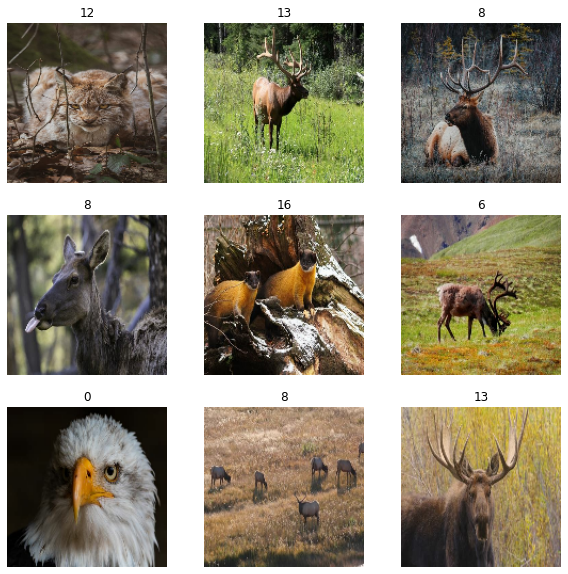

In [6]:
# Choosing and showing 9 random images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Pre-fetching the data to optimize loading speed:

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Data Augmentation
To create the effect of a larger dataset, one can modify the current dataset images to create more diversity and data samples. In the folowing sample, two data augmentation methods of random horizontal flipping and random rotation are introduced. More about data augmentation methods can be found [here](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/).

Sequential method is an easy method to stack multiple layers of neural network on each other. You can read more about it [here](https://keras.io/guides/sequential_model/).

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

Here is a quick visualization of the data augmentation method defined on a random image:

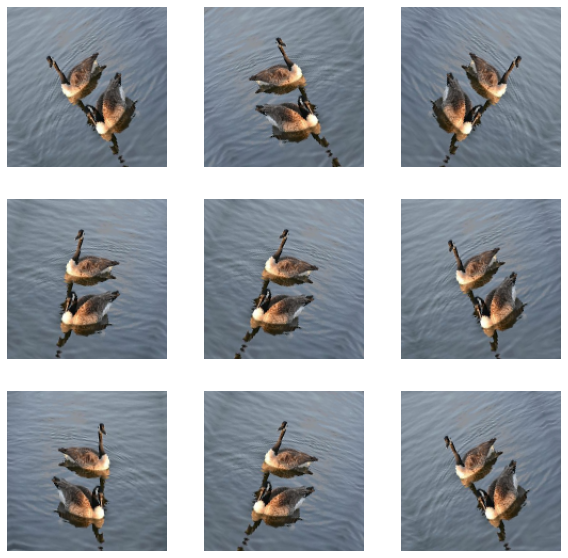

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

The input to a neural network should generally be small; therefore, we standardize the data by adding an extra layer to data augmentation: 
```
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
```

**NOTE:** Data augmentation is only active during training time and will be bypassed during evaluation or prediction.



## Model creation
In the following code, 
1. We define a Xception model as base model using transfer learning.
2. Freezing the network 
3. Adding layers

In [10]:
base_model = keras.applications.Xception(
    weights="imagenet",  
    input_shape=(150, 150, 3),
    include_top=False
) 

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation


norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x = norm_layer(x)
norm_layer.set_weights([mean, var])


x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(21)(x)
model = keras.Model(inputs, outputs)

model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 21)                43029     
Total params: 20,904,516
Trainable params: 43,029
Non-trainabl

## Training the Model
Parameters used here are Adam optimizer, SparseCategoricalCrossentropy loss, SparseCategoricalAccuracy as metrics. Because we have 21 classes.

In [11]:

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

Fitting the model on train image dataset with validation dataset.

In [12]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
53/53 [==============================] - 457s 8s/step - loss: 2.1194 - sparse_categorical_accuracy: 0.3697 - val_loss: 0.8620 - val_sparse_categorical_accuracy: 0.6995
Epoch 2/10
53/53 [==============================] - 6s 106ms/step - loss: 0.8798 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.7657 - val_sparse_categorical_accuracy: 0.7620
Epoch 3/10
53/53 [==============================] - 6s 107ms/step - loss: 0.7106 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.7339 - val_sparse_categorical_accuracy: 0.7644
Epoch 4/10
53/53 [==============================] - 6s 106ms/step - loss: 0.6020 - sparse_categorical_accuracy: 0.8105 - val_loss: 0.7286 - val_sparse_categorical_accuracy: 0.7524
Epoch 5/10
53/53 [==============================] - 6s 108ms/step - loss: 0.5599 - sparse_categorical_accuracy: 0.8239 - val_loss: 0.6872 - val_sparse_categorical_accuracy: 0.7885
Epoch 6/10
53/53 [==============================] - 6s 108ms/step - loss: 0.5019 - sparse_categorical

## Plotting Loss and Accuracy of Train and Validation.
Here i'm plotting the model accuracy and model loss for both train and validation.


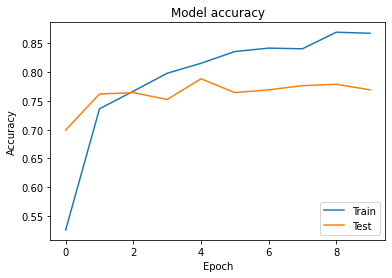

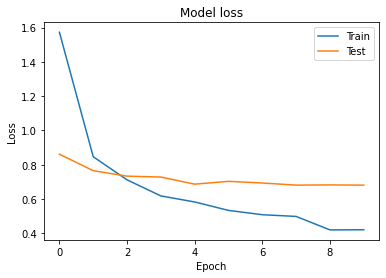

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [14]:
loss, accuracy = model.evaluate(val_ds)
print('Validation accuracy :', accuracy)

13/13 [==============================] - 1s 65ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.7692
Validation accuracy : 0.7692307829856873



**Explanation for model without tuning**
From the accuracy curve above, we can see that the accuracy of the training set is increasing with respect to epochs and reaches 86.42%, the validation set accuracy increases a little but not too much and reached to 76.92%.

From the Loss curve, we can see that as the loss decreases w.r.t epochs, training set shows more increase than validation set. Which is a good sign.

Here we got less no of images to predict the 21 classes, so we got less accuracy and more loss. So here we are doing tuning and more data augmentation for better performance.

## Visualizing Confusion Matrix

In [15]:
val_true = tf.concat([y for x, y in val_ds], axis=0)

In [16]:
val_lab = model.predict(val_ds)

val_pred = tf.argmax(val_lab, axis=1)

In [17]:
confusion_matrix = tf.math.confusion_matrix(val_true,val_pred,num_classes=21)


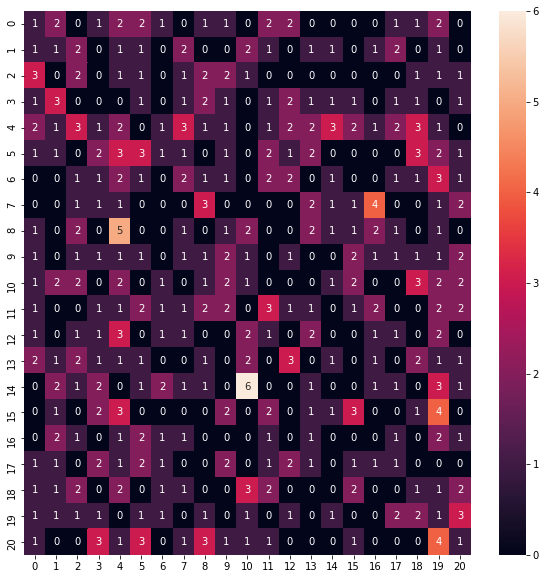

In [18]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix,annot=True)

## Tuning the model

Data augmentation is updated by removing rotation and adding zoom.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(150, 
                                                              150,
                                                              3)),
  #  layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [20]:
from tensorflow.keras.models import Sequential

Here our model has converged on the new data, now i'm trying to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

In [21]:
base_model.trainable = True


In [22]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


In [23]:
base_learning_rate = 0.0001

In [24]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [25]:
fine_tune_epochs = 15
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/25
53/53 [==============================] - 12s 138ms/step - loss: 0.3441 - accuracy: 0.8921 - val_loss: 0.6763 - val_accuracy: 0.7933
Epoch 11/25
53/53 [==============================] - 7s 122ms/step - loss: 0.3141 - accuracy: 0.8983 - val_loss: 0.6869 - val_accuracy: 0.7885
Epoch 12/25
53/53 [==============================] - 7s 125ms/step - loss: 0.2685 - accuracy: 0.9073 - val_loss: 0.6827 - val_accuracy: 0.7933
Epoch 13/25
53/53 [==============================] - 7s 126ms/step - loss: 0.2369 - accuracy: 0.9189 - val_loss: 0.7012 - val_accuracy: 0.8005
Epoch 14/25
53/53 [==============================] - 7s 125ms/step - loss: 0.2450 - accuracy: 0.9258 - val_loss: 0.7107 - val_accuracy: 0.7909
Epoch 15/25
53/53 [==============================] - 7s 125ms/step - loss: 0.2131 - accuracy: 0.9264 - val_loss: 0.7055 - val_accuracy: 0.7909
Epoch 16/25
53/53 [==============================] - 7s 125ms/step - loss: 0.2100 - accuracy: 0.9267 - val_loss: 0.7147 - val_accuracy: 0.793

##Plotting Loss and Accuracy of Train and Validation after tuning

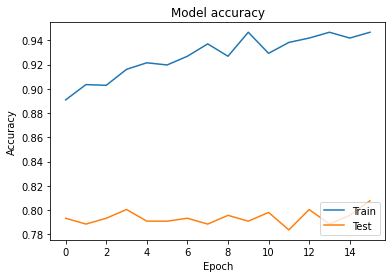

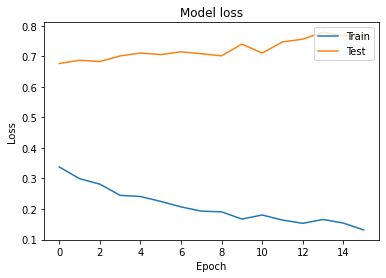

In [26]:
# Plot training & validation accuracy values
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [28]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy*100)

13/13 [==============================] - 2s 67ms/step - loss: 0.7675 - accuracy: 0.8077
Test accuracy : 80.7692289352417


Here we can see clearly that after tuning and adding data augmentation. We are getting more accuracy on validation dataset of 80.77%. 